# Spike sorting using PCA and k-means clustering

This is a spike-sorting algorithm I designed for analysing the neuronal data I collected from the barrel cortex. There are many spike sorting algorithms available, but most of them are only suited for a specific "flavour" of neuronal data: some work better for tetrodes, others -- for hippocampal recordings (they tend to have a lot of units close together with very different shapes), still others -- for sharp electrodes. I constructed this particular algorithm to suite my needs of transparency and high customization for sorting single-electrode recordings from the barrel cortex, and to give me a baseline of how well the spikes can be sorted. In this notebook I demonstrate how it works by taking the data from its original form as raw recording (made with Tucker-Davis Technologies RZ2 recording system) to spiketimes with cluster labels, which later can be used for the analysis of neuronal coding.

In [1]:
import numpy as np
import pandas as pd
import scipy


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('poster',rc={"lines.linewidth": 1})

import gc # garbage collector

In [2]:
# path to raw recording file
sev_file_path = r'D:\Work\data\sorting_test\20160710S8_Block-1_Raw1_Ch15.sev'

In [3]:
import os
import re
import struct

def read_sev(name):
    """
    Parse SEV data files, this function is courtesy of TDT engineers.
    """
    if os.path.isfile(name):
        fileName, fileExtension = os.path.splitext(name)
        if fileExtension.lower() != '.sev':
            print('not a valid SEV file')
            return
        print('importing data from single SEV file:', name)
    else:
        print('not a valid file')
        return None

    ALLOWED_FORMATS = [np.float32, np.int32, np.int16, np.int8, np.float64, np.int64]        
    
    f = open(name, 'rb')
    head = f.read(40)
        
    fileSizeBytes, fileType, fileVersion, eventName, channelNum, \
    totalNumChannels, sampleWidthBytes, reserved1, dForm, \
    decimate, rate, reserved2 = struct.unpack('Q3sB4sHHHHBBHQ',head)

    if fileType.decode().lower() != 'sev':
        print('bad file type'), fileType
        return None
        
    if fileVersion > 2:
        print('unknown version:'), fileVersion
        return None
        
    if fileVersion < 2:
        eventName = eventName[::-1]

    if fileVersion > 0:
        # determine data sampling rate
        print (type(rate), type(decimate))
        fs = 2.**(float(rate))*25000000./2.**12./float(decimate)
    else:
        dForm = 0
        fs = 0
        parts = sev_file.split('_')
        eventName = parts[-2]
        channelNum = int(re.search(r'\d+', parts[-1]).group())
        print('Warning - empty header; assuming {0} store, Ch {1} format {2} and fs',
               ' = {3}\nupgrade to OpenEx v2.18 or above for proper header',
               ' information\n'.format(eventName,  channelNum, dForm, 24414.0625))
        
        fs = 24414.0625

    fmt = ALLOWED_FORMATS[dForm & 7]
    
    d = dict()
    d['fileSizeBytes']    = fileSizeBytes
    d['fileType']         = fileType
    d['fileVersion']      = fileVersion
    d['eventName']        = eventName
    d['channelNum']       = channelNum
    d['totalNumChannels'] = totalNumChannels
    d['sampleWidthBytes'] = sampleWidthBytes
    d['dForm']            = dForm
    d['decimate']         = decimate
    d['rate']             = rate
    d['fs']               = fs
    d['fmt']              = fmt
    d['data']             = np.fromfile(f, dtype=fmt)
    
    if fileVersion > 0:
        # verify streamHeader is 40 bytes
        streamHeaderSizeBytes = d['fileSizeBytes'] - len(d['data']) * d['sampleWidthBytes'];
        if streamHeaderSizeBytes != 40:
            print('Warning - Header Size Mismatch -- {0} bytes vs 40 bytes'.format(streamHeaderSizeBytes))
            
    return d

In [4]:
# load data into memory
d = read_sev(sev_file_path)

importing data from single SEV file: D:\Work\data\sorting_test\20160710S8_Block-1_Raw1_Ch15.sev
<class 'int'> <class 'int'>


In [5]:
# take a 1/10 of the recording to speed up the algorithm for the illustration purposes
d['data'] = d['data'][:int(len(d['data'])/10)]

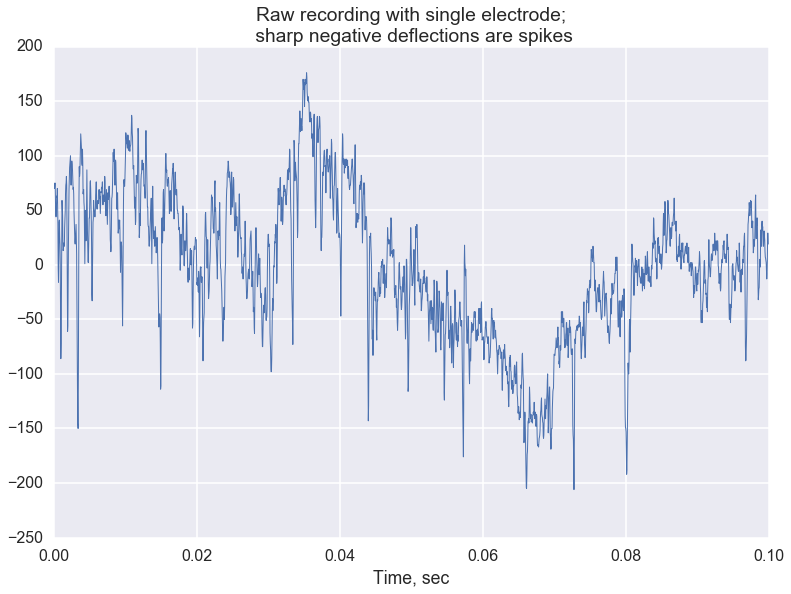

In [6]:
# sampling frequency
fs = d['fs']

# slice of 0.1 sec used to plot pieces of waveform for visual examination
fragment = slice(0,int(fs/10),1)

# time vector
t = np.arange(0,len(d['data']))/fs

plt.plot(t[fragment],d['data'][fragment])
plt.xlabel('Time, sec')
plt.title('Raw recording with single electrode;\n sharp negative deflections are spikes')
plt.show()

First I filter data to dampen lower frequencies (< 200 Hz) and possible high-frequency noise (> 8000 Hz). It is very important to design a filter that has a zero phase delay, because I want to preserve waveforms as much as possible (they are crucial for clustering the units later). Therefore I use Butterworth filter forward and then backward.

In [7]:
## functions for filter design

from scipy.signal import butter, lfilter, freqz

def butter_bandpass(lowcut, highcut, fs, order):
    """
    Call scipy.signal.butter after transforming the cutoff frequencies from Hz to values
    normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample.
    This is required for digital filter function.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    """
    Calculate IIR of butterworth filter and apply filter to the data.
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def zero_phase_filt(data, filter_function, lowcut, highcut, fs, order):
    """
    Forward + backward filtering for zero phase delay.
    """
    # forward filter
    data = filter_function(data, lowcut, highcut, fs, order=order)
    # backward filter
    data = filter_function(np.flipud(data), lowcut, highcut, fs, order=order)
    # flip
    data = np.flipud(data)
    return data

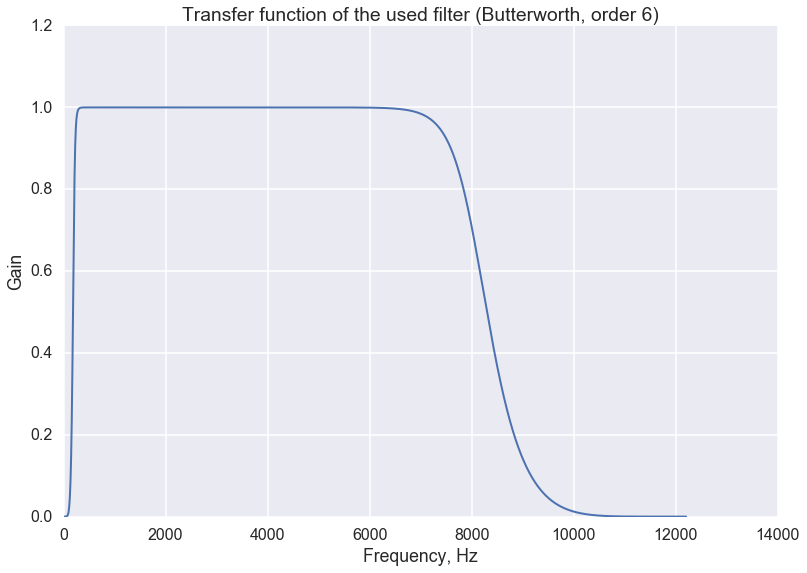

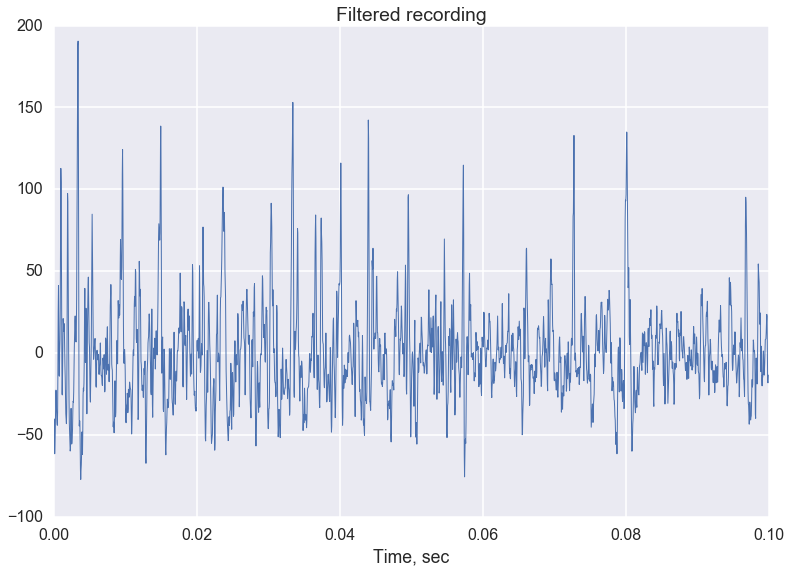

In [8]:
# cutoff frequencies in Hz: spike range
lowcut = 200.0
highcut = 8000.0

# order of the filter
order = 6

# visualize filter transfer function in the frequency domain
b, a = butter_bandpass(lowcut, highcut, fs, order=order)
w, h = freqz(b, a, worN=2000)
plt.plot((fs * 0.5 / np.pi) * w, abs(h),linewidth=2)
plt.ylabel('Gain')
plt.ylim([0,1.2])
plt.xlabel('Frequency, Hz')
plt.title('Transfer function of the used filter (Butterworth, order %s)' % order)
plt.show()

# filter data
data = zero_phase_filt(d['data'], butter_bandpass_filter, 
                       lowcut, highcut, fs, order=order)

# reflect data to have positive spike depolarization peaks
data = -data

# plot filtered recording
plt.plot(t[fragment],data[fragment])
plt.xlabel('Time, sec')
plt.title('Filtered recording')
plt.show()

Recording can be roughly thought of as noise (normally distributed) + spikes (outliers). For detecting spikes I want to estimate the variability of noise component. Using standart deviation would be wrong here, because the recording is not normally distributed (it has spikes, potentially a lot of them), and STD would overestimate variability. Instead I use median absolute deviation, which is a more robust measure of distribution variability.

In [9]:
def mad(x):
    """
    Returns the Median Absolute Deviation of its argument.
    """
    return np.median(np.absolute(x - np.median(x)))*1.4826

# center around median and normalize on median absolute deviation 
data = (data-np.median(data))/mad(data)

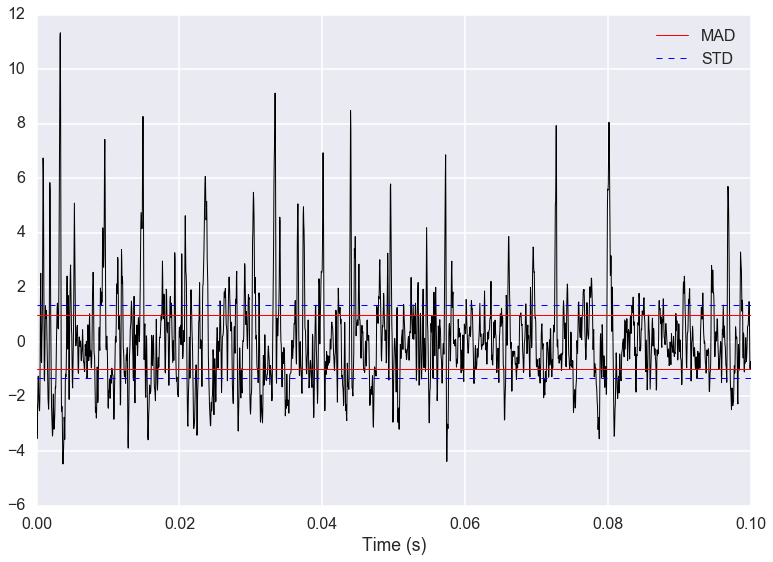

In [10]:
# visualize normalized data and compare STD and MAD

plt.plot(t[fragment],data[fragment],color="black",linewidth=1)
plt.axhline(y=1,color="red",label='MAD')
plt.axhline(y=-1,color="red")
plt.axhline(y=np.std(data),color="blue",linestyle="dashed",label='STD')
plt.axhline(y=-np.std(data),color="blue",linestyle="dashed")
plt.xlabel('Time (s)')
plt.legend(loc='best')
plt.show()

Next step is detecting spikes. I do it by thresholding on 3*MAD.

In [11]:
from scipy.signal import fftconvolve

# do running window average to smooth for peak detection
length_of_filter = 4
data_filtered = fftconvolve(data,np.array([1]*length_of_filter)/length_of_filter,'same')

# restore normalized amplitude
data_filtered = data_filtered/mad(data_filtered)

# rectify at threshold
threshold = 3
data_filtered[data_filtered < threshold] = 0

gc.collect()

17726

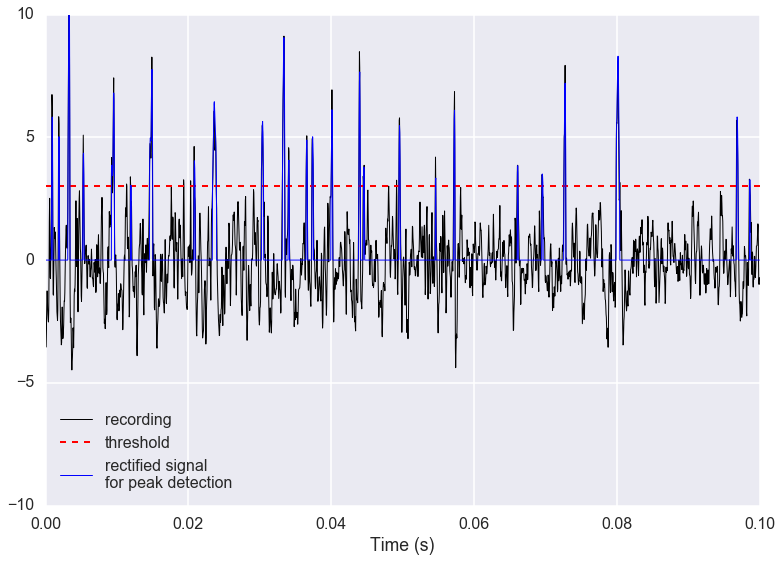

In [12]:
plt.plot(t[fragment], data[fragment],'k',label='recording')
plt.axhline(threshold,color='r',linestyle='dashed',linewidth=2,label='threshold')
plt.plot(t[fragment], data_filtered[fragment],color='b',label='rectified signal\nfor peak detection')
plt.xlim([0,0.1])
plt.ylim([-10,10])
plt.legend(loc='best')
plt.xlabel('Time (s)')

plt.show()

In [13]:
def peak(x, min_dist=10):
    """
    Returns indexes of the peaks of one-dimensional array, 
    which are at least *min_dist* samples apart.
    """
    # first derivative
    dx = scipy.signal.fftconvolve(x,np.array([1,0,-1])/2.,'same') 
    # remove artifacts of the convolution
    dx[np.abs(dx) < 1e-3] = 0
    # sign of derivative (removes noise in the peak shape)
    dx = np.sign(dx)
    # second derivative
    ddx = np.diff(dx)
    # positiong of the peaks (second derivative is negative)
    pos = np.arange(len(ddx))[ddx < 0]
    # return positions of the peaks which are >*min_dist* apart
    return pos[:-1][np.diff(pos) > min_dist]

In [14]:
# detect peaks
sp0 = peak(data_filtered)
print('Detected peaks: %s' % len(sp0))

Detected peaks: 49752


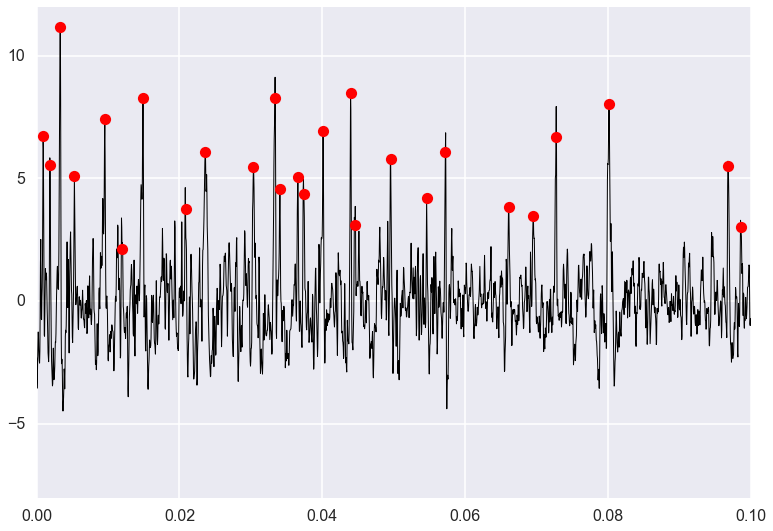

In [15]:
# visualize detected peaks
plt.plot(t[fragment],data[fragment],linewidth=1,color='black')
plt.plot(t[sp0],data[sp0],'ro')
plt.xlim([0,0.1])
plt.ylim([-8,12])
plt.show()

In [16]:
def cut_event(pos,data,before=14, after=30):
    """
    Cut an event from position *pos*-*before* to *pos*+*after*.
    Takes care of the boundary events, by padding zeros on the side
    of the boundary.
    """
    # data length
    dl = len(data)
    # cut length
    cl = before+after+1
    # preallocate event vector
    event = np.zeros(cl)
    # indexes of the event around 0
    idx = np.arange(-before,after+1)
    # indexes of the event at position
    keep = idx + pos
    # check if the event goes out of bounds of recording
    within = np.bitwise_and(0 <= keep, keep < dl)
    # keep only indexes within the recording
    kw = keep[within]
    # make a cut
    event[within] = data[kw]
    
    return event

def extract_events(positions, data, before=14, after=30):
    """
    Cut all events around *positions* from *data*.
    """
    # preallocate dataframe for the events
    events = pd.DataFrame(np.zeros([len(positions),before+after+1]))

    # cut all events
    for i,p in enumerate(positions):
        events.loc[i,:] = cut_event(p,data,before,after)
        
    return events

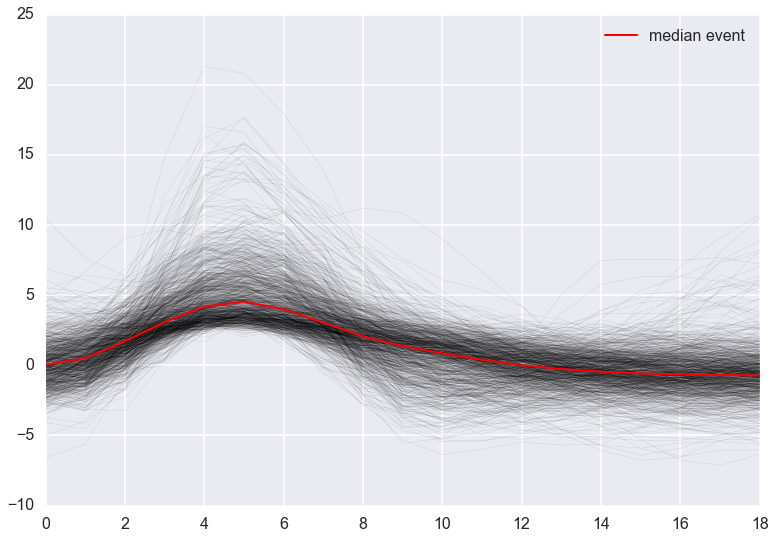

In [17]:
# get all spike waveforms
events = extract_events(sp0,data,5,13)

# visualize a sample of waveforms
events_median=events.apply(np.median,0)

plt.plot(events.sample(1000).transpose(),linewidth=0.05,c='k')
plt.plot(events_median,linewidth=2,c='r',label='median event')
plt.legend(loc='best')
plt.show()

Perform principal component analysis on the spike waveforms

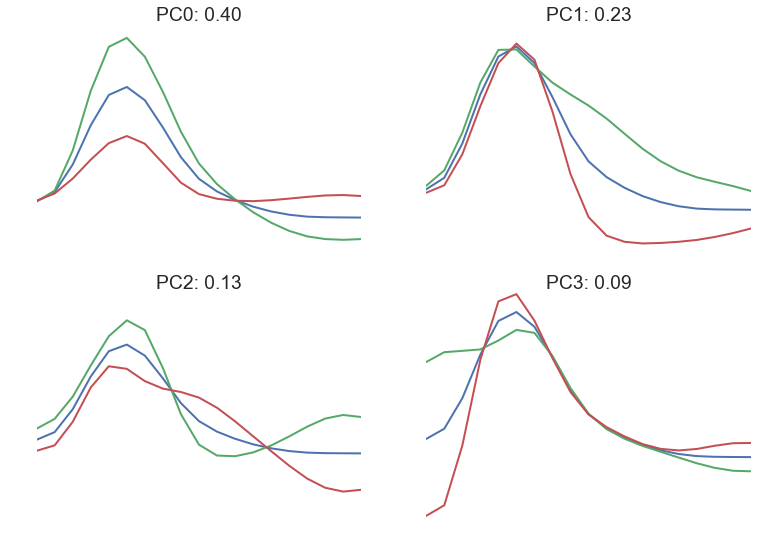

In [18]:
from sklearn.decomposition import PCA

waveform_pca = PCA(n_components=4)
waveform_pca.fit(events)

# visualize 4 first principal components and the variance they explain
waveform_mean = np.mean(events,0)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(waveform_mean, linewidth=2)
    plt.plot(waveform_mean + 5*waveform_pca.components_[i],linewidth=2)
    plt.plot(waveform_mean - 5*waveform_pca.components_[i],linewidth=2)
    plt.axis('off')
    plt.title('PC%s: %.4s' % (i, waveform_pca.explained_variance_ratio_[i]))

In [19]:
# calculate projections of all waveform onto the first 4 components
events_features = pd.DataFrame(np.dot(events,waveform_pca.components_[:4].T), 
                               columns = ['PC%s' % i for i in range(4)])

# add peak amplitude
events_features['peak_amp'] = np.max(events,axis=1)

events_features.head()

,PC0,PC1,PC2,PC3,peak_amp
0,7.870126,0.719357,6.857137,-2.361580,6.739869
1,10.027488,-7.235789,0.767252,-3.355902,5.838419
2,23.217426,-5.573646,5.090923,1.920526,11.330408
3,7.384045,1.036709,2.993802,-2.112682,5.089008
4,13.136544,-0.174987,3.498216,3.283386,7.421300


D:\Programs\Anaconda\envs\py35\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


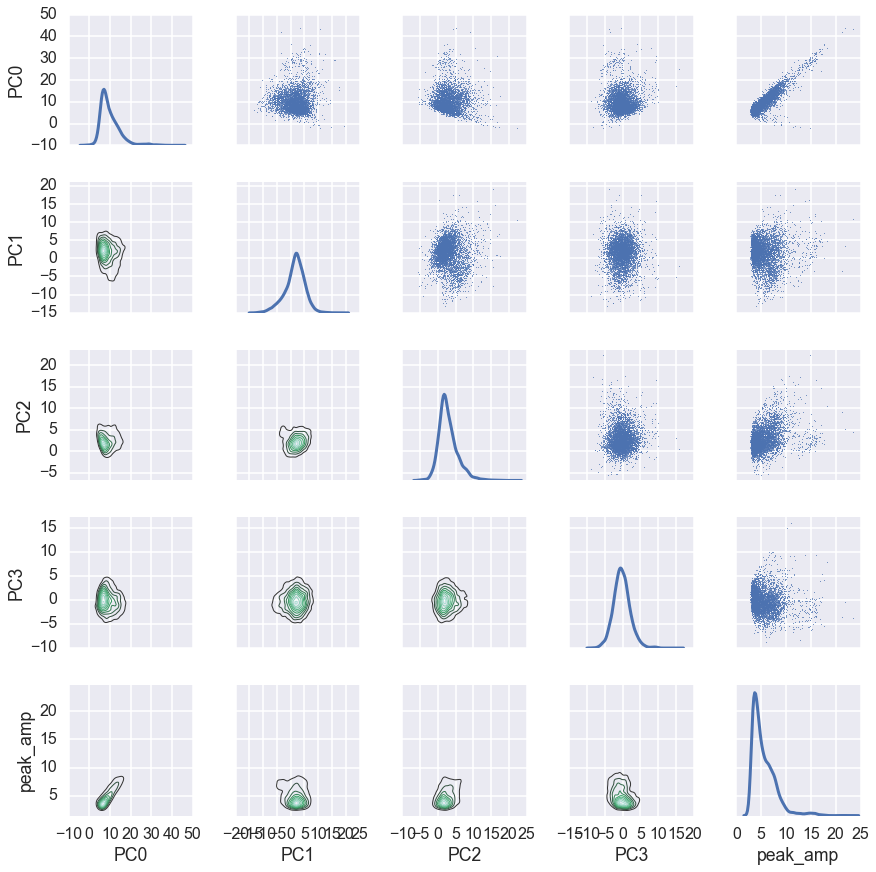

In [20]:
# visualize 2D projections of features
g = sns.PairGrid(events_features.sample(5000))
g = g.map_upper(plt.scatter,s=0.2)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.kdeplot, lw=3, legend=False)

Next I perform clustering using k-means algorithm. K-means is not the best clustering algorithm for these data, because they violate a lot of assumptions needed for successful k-means clustering, such as similar cluster size, similar variance of the clusters and spherical shape of the clusters. Because of that, density-based clustering is usually more successful, given correct parameters. However, k-means does a good enough job in most cases, it is fast and has only one parameter (number of clusters), so it doesn't require gridsearch or genetic algorithms to work well. Therefore, here I use it to give a background estimate of clustering quality.

In [21]:
# perform clustering using Kmeans
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4,random_state=0).fit(events_features)
events_features['cl'] = km.labels_
print('Number of events in each cluster:')
print(events_features.groupby('cl').count()['PC0'])

Number of events in each cluster:
cl
0    10792
1     1724
2    28582
3     8654
Name: PC0, dtype: int64


D:\Programs\Anaconda\envs\py35\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


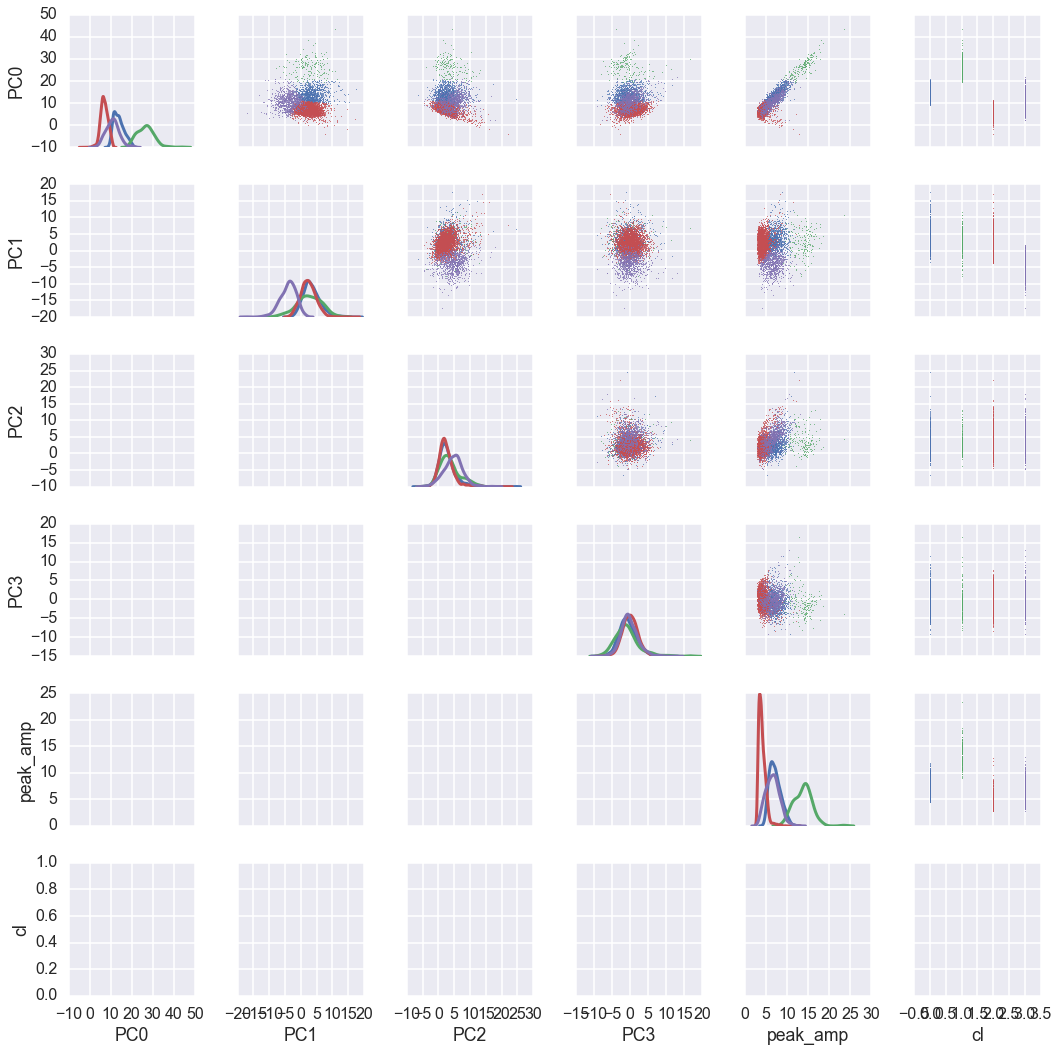

In [22]:
# visualize 2D projections of features with cluster label
g = sns.PairGrid(events_features.sample(5000),hue='cl')
g = g.map_upper(plt.scatter,s=0.2)
g = g.map_diag(sns.kdeplot, lw=3, legend=False)

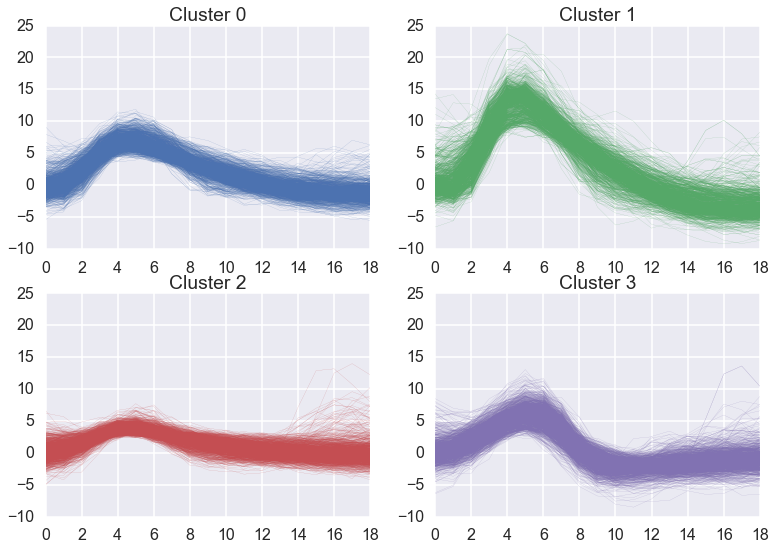

In [23]:
# visualize waveforms from different clusters

for cl in np.sort(events_features.cl.unique()):
    for i in range(4):
        plt.subplot(2,2,cl+1)
        plt.plot(events.loc[events_features.cl==cl].sample(300).T,
                 color=sns.color_palette()[cl],linewidth=0.1)
        plt.ylim([-10,25])
        plt.title('Cluster %s' % cl)
plt.show()

In [24]:
# save spiketimes (in seconds) and cluster labels for future analysis
spiketimes = pd.DataFrame([pd.Series(sp0/fs),events_features.cl]).T
spiketimes.columns = ['t','cluster']
spiketimes.to_csv('spiketimes.csv')

spiketimes.head(10)

,t,cluster
0,0.000901,2.0
1,0.001884,3.0
2,0.003277,1.0
3,0.005284,2.0
4,0.009544,0.0
5,0.011960,2.0
6,0.014868,0.0
7,0.020849,3.0
8,0.023593,0.0
9,0.030351,0.0
